### **Importing libs**

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.patches import Rectangle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import albumentations
from tensorflow.python.ops.numpy_ops import np_config
!pip install numpy==1.19.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Visualizaton**

In [ ]:
def visualize_detections(image, boxes, classes, scores, figsize=(10, 10), linewidth=1):
  image = np.array(image, dtype=np.uint8)
  plt.figure(figsize=figsize)
  plt.axis("off")
  plt.imshow(image)
  ax = plt.gca()
  for box, _cls, score in zip(boxes, classes, scores):
    if _cls == "lung":
      color = "purple"
    else:
      color = "r"
    text = "{}: {:.2f}".format(_cls, score)
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    patch = Rectangle([x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth)
    ax.add_patch(patch)
    ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True)
  plt.show()
  return ax

In [ ]:
image = load_img("/content/drive/MyDrive/Colab Notebooks/COVID_data/detection/data/imgs/COVID(183).png")
image = img_to_array(image)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/COVID_data/detection/data/labels/COVID(183).csv")
boxes = []
classes = []
scores = []
for i in range(len(df)):
  xmin = df.iloc[i]["bndbox/xmin"]
  ymin = df.iloc[i]["bndbox/ymin"]
  xmax = df.iloc[i]["bndbox/xmax"]
  ymax = df.iloc[i]["bndbox/ymax"]
  boxes.append([xmin, ymin, xmax, ymax])
  classes.append(df.iloc[i]["name"])
  scores.append(1)

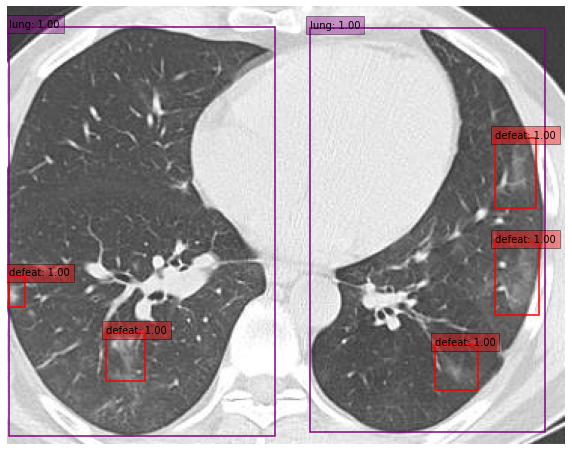

In [ ]:
visualize_detections(image, boxes, classes, scores, linewidth=1.5)

### **Data**

In [ ]:
DIRECTORY = "/content/drive/MyDrive/Colab Notebooks/COVID_data/detection/data"

train_df, val_df = train_test_split(pd.read_csv(os.path.join(DIRECTORY, "data_names.csv")), test_size=0.1)

train_df.shape, val_df.shape

((200, 1), (23, 1))

In [ ]:
def create_generator(names_df, is_test=False):
  def generator():
    names = names_df["names"]
    
    for name in names:
      boxes = []
      classes = []

      image = load_img(os.path.join(DIRECTORY, "imgs", f"{name}.png"))
      image = img_to_array(image)

      h, w = image.shape[:2]
   
      with open(os.path.join(DIRECTORY, "labels", f"{name}.csv"), 'r') as f:
        box_rows = [l.strip().split(',') for l in f.readlines()[1:]]

      for row in box_rows:
        xmin, ymin, xmax, ymax = list(map(int, row[4:8]))
        if is_test == True:
          boxes.append([xmin, ymin, xmax, ymax])
        else:
          boxes.append([xmin / w, ymin / h, xmax / w, ymax / h])
        if row[0] == "defeat":
          classes.append(1)
        else:
          classes.append(0)

      boxes = tf.convert_to_tensor(boxes)
      classes = tf.convert_to_tensor(classes)
    
      yield image, boxes, classes
  
  return generator

train_gen = create_generator(train_df)
val_gen = create_generator(val_df)
test_gen = create_generator(val_df, is_test=True)

train_dataset = tf.data.Dataset.from_generator(train_gen, 
                                      output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
                                                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                        tf.TensorSpec(shape=(None,), dtype=tf.int32)))
val_dataset = tf.data.Dataset.from_generator(val_gen, 
                                      output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
                                                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                        tf.TensorSpec(shape=(None,), dtype=tf.int32)))
test_dataset = tf.data.Dataset.from_generator(test_gen, 
                                      output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
                                                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                        tf.TensorSpec(shape=(None,), dtype=tf.int32)))

In [ ]:
list(train_dataset.take(1))

[(<tf.Tensor: shape=(380, 611, 3), dtype=uint8, numpy=
  array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8)>,
  <tf.Tensor: shape=(3, 4), dtype=float32, nu

In [ ]:
list(val_dataset.take(1))

[(<tf.Tensor: shape=(232, 319, 3), dtype=uint8, numpy=
  array([[[236, 236, 236],
          [234, 234, 234],
          [234, 234, 234],
          ...,
          [239, 239, 239],
          [237, 237, 237],
          [233, 233, 233]],
  
         [[240, 240, 240],
          [239, 239, 239],
          [237, 237, 237],
          ...,
          [235, 235, 235],
          [233, 233, 233],
          [231, 231, 231]],
  
         [[234, 234, 234],
          [233, 233, 233],
          [229, 229, 229],
          ...,
          [236, 236, 236],
          [234, 234, 234],
          [234, 234, 234]],
  
         ...,
  
         [[219, 219, 219],
          [216, 216, 216],
          [212, 212, 212],
          ...,
          [208, 208, 208],
          [204, 204, 204],
          [202, 202, 202]],
  
         [[204, 204, 204],
          [203, 203, 203],
          [201, 201, 201],
          ...,
          [209, 209, 209],
          [207, 207, 207],
          [207, 207, 207]],
  
         [[210, 210, 21

In [ ]:
list(test_dataset.take(1))

[(<tf.Tensor: shape=(232, 319, 3), dtype=uint8, numpy=
  array([[[236, 236, 236],
          [234, 234, 234],
          [234, 234, 234],
          ...,
          [239, 239, 239],
          [237, 237, 237],
          [233, 233, 233]],
  
         [[240, 240, 240],
          [239, 239, 239],
          [237, 237, 237],
          ...,
          [235, 235, 235],
          [233, 233, 233],
          [231, 231, 231]],
  
         [[234, 234, 234],
          [233, 233, 233],
          [229, 229, 229],
          ...,
          [236, 236, 236],
          [234, 234, 234],
          [234, 234, 234]],
  
         ...,
  
         [[219, 219, 219],
          [216, 216, 216],
          [212, 212, 212],
          ...,
          [208, 208, 208],
          [204, 204, 204],
          [202, 202, 202]],
  
         [[204, 204, 204],
          [203, 203, 203],
          [201, 201, 201],
          ...,
          [209, 209, 209],
          [207, 207, 207],
          [207, 207, 207]],
  
         [[210, 210, 21

### **Creating and fitting model**

In [ ]:
def swap_xy(boxes):
  return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
  return tf.concat([(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1)


def convert_to_corners(boxes):
  return tf.concat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1)

In [ ]:
def iou(boxes1, boxes2):  # Interception over Union function
  boxes1_corners = convert_to_corners(boxes1)
  boxes2_corners = convert_to_corners(boxes2)
  lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
  rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
  intersection = tf.maximum(0.0, rd - lu)
  intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
  boxes1_area = boxes1[:, 2] * boxes1[:, 3]
  boxes2_area = boxes2[:, 2] * boxes2[:, 3]
  union_area = tf.maximum(
      boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
  )
  
  return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [ ]:
class AnchorBox:  # class for generating Anchor boxes
  def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

  def _compute_dims(self):
    anchor_dims_all = []
    for area in self._areas:
      anchor_dims = []
      for ratio in self.aspect_ratios:
        anchor_height = tf.math.sqrt(area / ratio)
        anchor_width = area / anchor_height
        dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
        for scale in self.scales:
          anchor_dims.append(scale * dims)
      anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
    return anchor_dims_all

  def _get_anchors(self, feature_height, feature_width, level):
    rx = tf.range(feature_width, dtype=tf.float32) + 0.5
    ry = tf.range(feature_height, dtype=tf.float32) + 0.5
    centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
    centers = tf.expand_dims(centers, axis=-2)
    centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
    dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
    anchors = tf.concat([centers, dims], axis=-1)
    return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

  def get_anchors(self, image_height, image_width):
    anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
    return tf.concat(anchors, axis=0)

In [ ]:
def random_flip_horizontal(image, boxes):
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)

  return image, boxes


def resize_and_pad_image(image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0):
  image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
  if jitter is not None:
    min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
  ratio = min_side / tf.reduce_min(image_shape)
  if ratio * tf.reduce_max(image_shape) > max_side:
      ratio = max_side / tf.reduce_max(image_shape)
  image_shape = ratio * image_shape
  image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
  padded_image_shape = tf.cast(tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32)
  image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
  
  return image, image_shape, ratio


def preprocess_data(image, boxes, classes):
  image, boxes = random_flip_horizontal(image, boxes)
  image, image_shape, _ = resize_and_pad_image(image)

  boxes = tf.stack(
        [
            boxes[:, 0] * image_shape[1],
            boxes[:, 1] * image_shape[0],
            boxes[:, 2] * image_shape[1],
            boxes[:, 3] * image_shape[0],
        ],
        axis=-1
    )
  boxes = convert_to_xywh(boxes)
  
  return image, boxes, classes

In [ ]:
class LabelEncoder:
  def __init__(self):
    self._anchor_box = AnchorBox()
    self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)


  def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):
    iou_matrix = iou(anchor_boxes, gt_boxes)
    max_iou = tf.reduce_max(iou_matrix, axis=1)
    matched_gt_idx = tf.argmax(iou_matrix, axis=1)
    positive_mask = tf.greater_equal(max_iou, match_iou)
    negative_mask = tf.less(max_iou, ignore_iou)
    ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))

    return matched_gt_idx, tf.cast(positive_mask, dtype=tf.float32), tf.cast(ignore_mask, dtype=tf.float32)


  def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance

        return box_target

  def _encode_sample(self, image_shape, gt_boxes, cls_ids):
      anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
      cls_ids = tf.cast(cls_ids, dtype=tf.float32)
      matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
          anchor_boxes, gt_boxes
      )
      matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
      box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
      matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
      cls_target = tf.where(
          tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
      )
      cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
      cls_target = tf.expand_dims(cls_target, axis=-1)
      label = tf.concat([box_target, cls_target], axis=-1)

      return label

  def encode_batch(self, batch_images, gt_boxes, cls_ids):
      images_shape = tf.shape(batch_images)
      batch_size = images_shape[0]

      labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
      for i in range(batch_size):
          label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
          labels = labels.write(i, label)
      batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)

      return batch_images, labels.stack()

In [ ]:
def get_backbone():
  backbone = ResNet50(False, "imagenet", input_shape=[None, None, 3])
  c3_output, c4_output, c5_output = [backbone.get_layer(layer_name).output for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
  
  return keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output])

In [ ]:
class FeaturePyramid(layers.Layer):
  def __init__(self, backbone=None, **kwargs):
    super(FeaturePyramid, self).__init__(name="FeaturePiramid", **kwargs)
    self.backbone = backbone if backbone else get_backbone()
    self.conv_c3_1x1 = layers.Conv2D(256, 1, 1, "same")
    self.conv_c4_1x1 = layers.Conv2D(256, 1, 1, "same")
    self.conv_c5_1x1 = layers.Conv2D(256, 1, 1, "same")
    self.conv_c3_3x3 = layers.Conv2D(256, 3, 1, "same")
    self.conv_c4_3x3 = layers.Conv2D(256, 3, 1, "same")
    self.conv_c5_3x3 = layers.Conv2D(256, 3, 1, "same")
    self.conv_c6_3x3 = layers.Conv2D(256, 3, 2, "same")
    self.conv_c7_3x3 = layers.Conv2D(256, 3, 2, "same")
    self.upsample_2x = layers.UpSampling2D(2)

  
  def call(self, images, training=False):
    c3_output, c4_output, c5_output = self.backbone(images, training=training)
    p3_output = self.conv_c3_1x1(c3_output)
    p4_output = self.conv_c4_1x1(c4_output)
    p5_output = self.conv_c5_1x1(c5_output)
    p4_output = p4_output + self.upsample_2x(p5_output)
    p3_output = p3_output + self.upsample_2x(p4_output)
    p3_output = self.conv_c3_3x3(p3_output)
    p4_output = self.conv_c4_3x3(p4_output)
    p5_output = self.conv_c5_3x3(p5_output)
    p6_output = self.conv_c6_3x3(c5_output)
    p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
    
    return p3_output, p4_output, p5_output, p6_output, p7_output

In [ ]:
def build_head(output_filters, bias_init):
  head = keras.Sequential([keras.Input(shape=[None, None, 256])])
  kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
  for _ in range(4):
      head.add(keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init))
      head.add(keras.layers.ReLU())
  head.add(keras.layers.Conv2D(output_filters, 
                               3, 
                               1,
                               padding="same",
                               kernel_initializer=kernel_init,
                               bias_initializer=bias_init))
  
  return head

In [ ]:
class RetinaNet(Model):
  def __init__(self, num_classes, backbone=None, **kwargs):
    super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
    self.fpn = FeaturePyramid(backbone)
    self.num_classes = num_classes

    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    self.cls_head = build_head(9 * num_classes, prior_probability)
    self.box_head = build_head(9 * 4, "zeros")


  def call(self, image, training=False):
    features = self.fpn(image, training=training)
    N = tf.shape(image)[0]
    cls_outputs = []
    box_outputs = []
    for feature in features:
        box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
        cls_outputs.append(
            tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
        )
    cls_outputs = tf.concat(cls_outputs, axis=1)
    box_outputs = tf.concat(box_outputs, axis=1)
    
    return tf.concat([box_outputs, cls_outputs], axis=-1)

In [ ]:
class DecodePredictions(layers.Layer):
  def __init__(
        self,
        num_classes=80,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )


  def _decode_box_predictions(self, anchor_boxes, box_predictions):
    boxes = box_predictions * self._box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    
    return boxes_transformed

  def call(self, images, predictions):
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
    anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
    box_predictions = predictions[:, :, :4]
    cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
    boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

    return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):
  def __init__(self, delta):
    super(RetinaNetBoxLoss, self).__init__(
        reduction="none", name="RetinaNetBoxLoss"
    )
    self._delta = delta

  def call(self, y_true, y_pred):
    difference = y_true - y_pred
    absolute_difference = tf.abs(difference)
    squared_difference = difference ** 2
    loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
    )
    
    return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
  def __init__(self, alpha, gamma):
    super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
    )
    self._alpha = alpha
    self._gamma = gamma


  def call(self, y_true, y_pred):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred
    )
    probs = tf.nn.sigmoid(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
    
    return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
  def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
    super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
    self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
    self._box_loss = RetinaNetBoxLoss(delta)
    self._num_classes = num_classes

  def call(self, y_true, y_pred):
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    box_labels = y_true[:, :, :4]
    box_predictions = y_pred[:, :, :4]
    cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32)
    cls_predictions = y_pred[:, :, 4:]
    positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
    ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
    clf_loss = self._clf_loss(cls_labels, cls_predictions)
    box_loss = self._box_loss(box_labels, box_predictions)
    clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
    box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
    normalizer = tf.reduce_sum(positive_mask, axis=-1)
    clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
    box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
    loss = clf_loss + box_loss
    
    return loss

In [ ]:
label_encoder = LabelEncoder()

num_classes = 2
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

In [ ]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
weights_dir = "/content/drive/MyDrive/Colab Notebooks/COVID_data/models/saved model/detection_model_weights/weights"

model.load_weights(weights_dir)

In [ ]:
autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
epochs = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

Epoch 1/50
100/100 [==============================] - 88s 872ms/step - loss: 3.9241 - val_loss: 3.9310
Epoch 2/50
100/100 [==============================] - 89s 882ms/step - loss: 3.8752 - val_loss: 3.7494
Epoch 3/50
100/100 [==============================] - 88s 874ms/step - loss: 3.3445 - val_loss: 2.6716
Epoch 4/50
100/100 [==============================] - 87s 857ms/step - loss: 2.3478 - val_loss: 1.8375
Epoch 5/50
100/100 [==============================] - 86s 855ms/step - loss: 1.7619 - val_loss: 1.7411
Epoch 6/50
100/100 [==============================] - 86s 848ms/step - loss: 1.9987 - val_loss: 1.8497
Epoch 7/50
100/100 [==============================] - 89s 877ms/step - loss: 1.7004 - val_loss: 1.5133
Epoch 8/50
100/100 [==============================] - 87s 859ms/step - loss: 1.5074 - val_loss: 1.1424
Epoch 9/50
100/100 [==============================] - 86s 848ms/step - loss: 1.1074 - val_loss: 0.9517
Epoch 10/50
100/100 [==============================] - 87s 871ms/step - l

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/COVID_data/models/saved model/detection_model_weights/weights")

### **Evaluating**

In [ ]:
model.evaluate(val_dataset)

23/23 [==============================] - 174s 7s/step - loss: 0.2362


0.23617848753929138

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.75)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

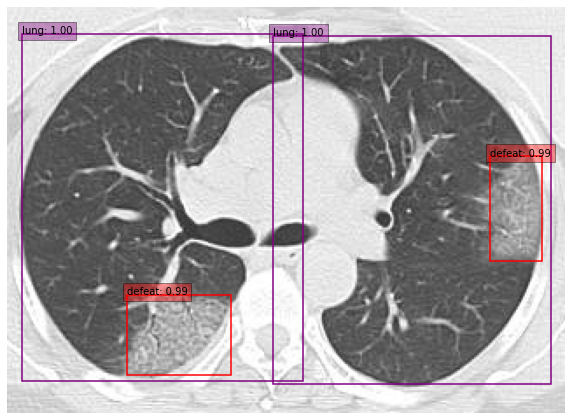

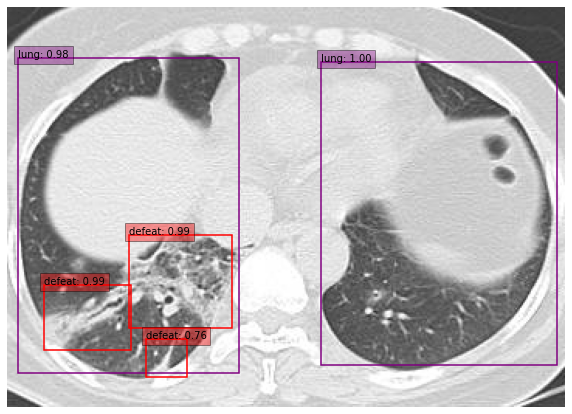

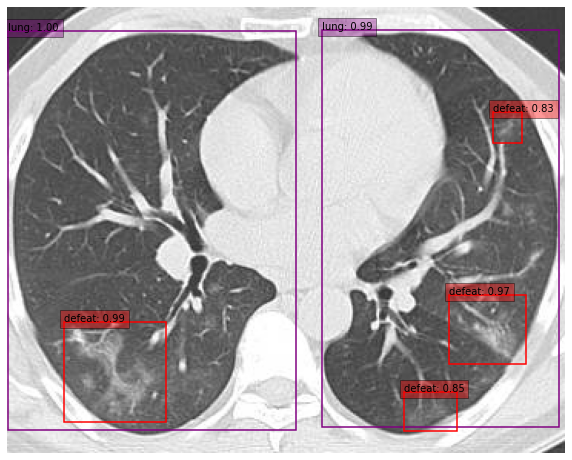

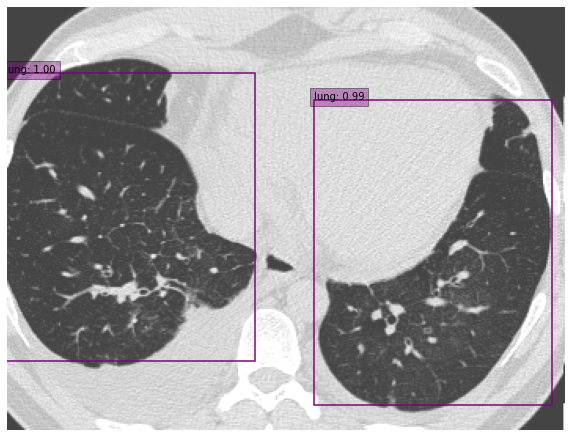

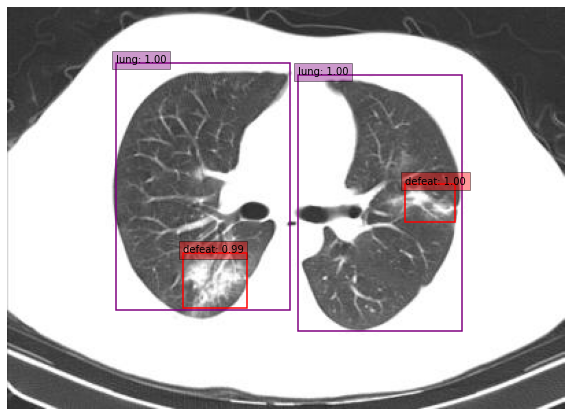

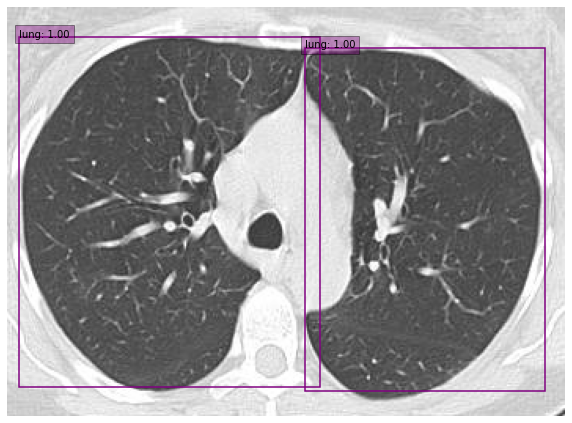

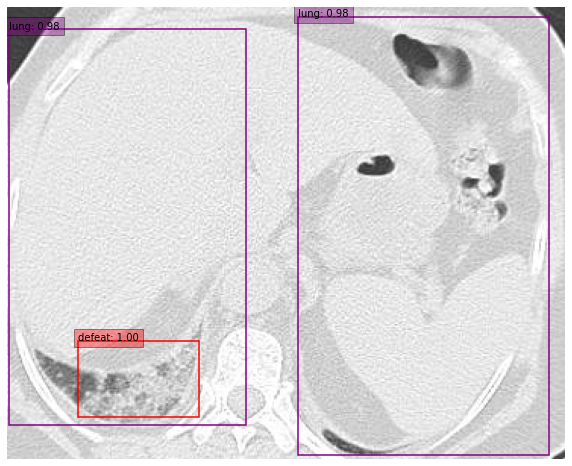

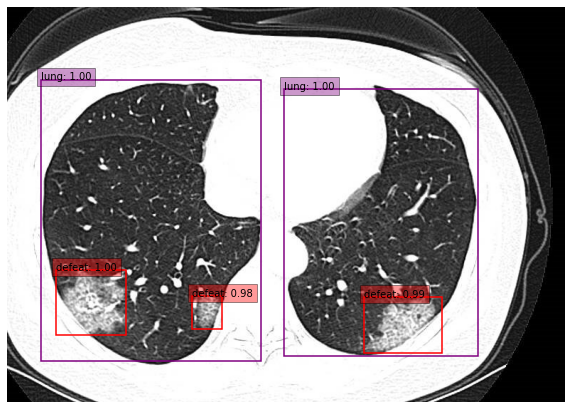

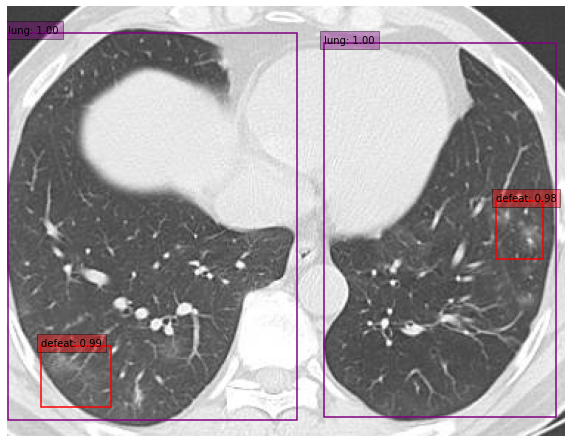

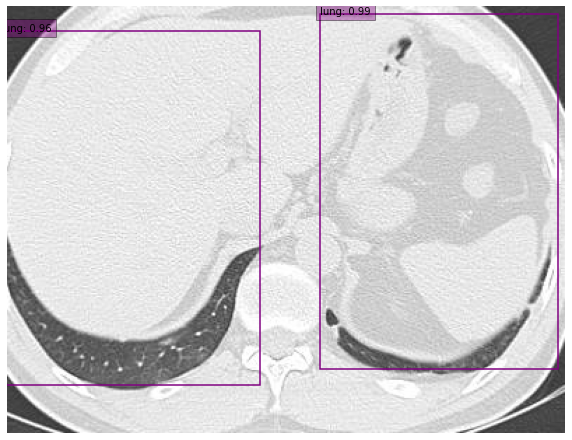

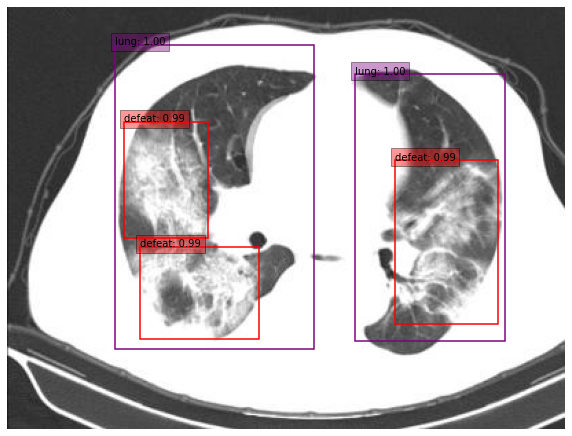

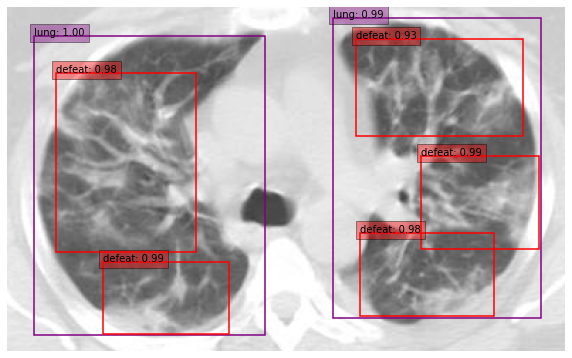

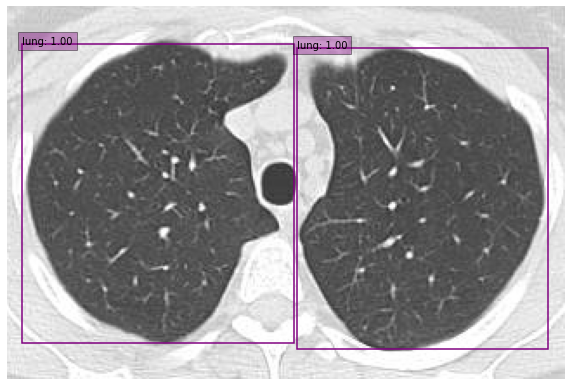

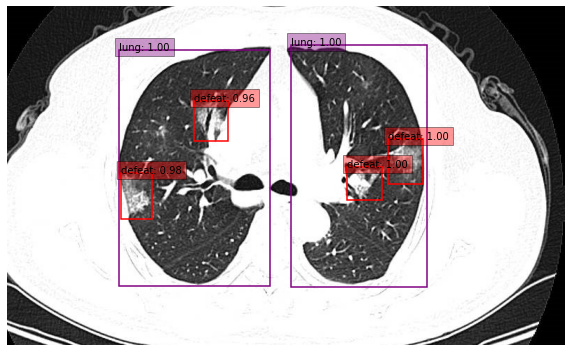

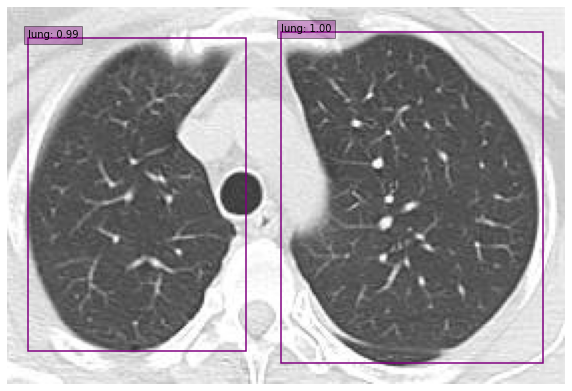

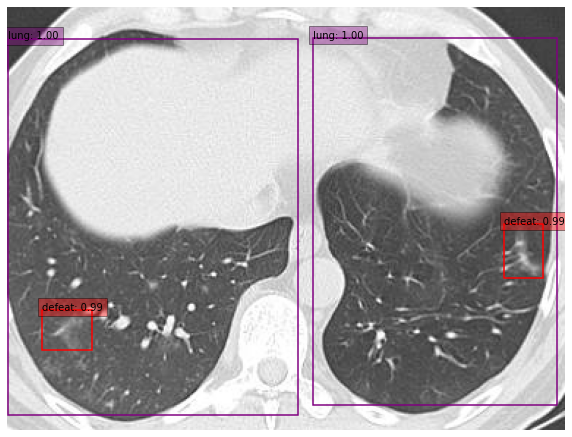

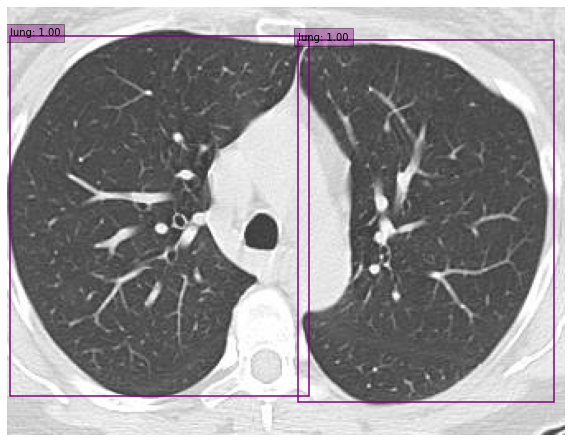

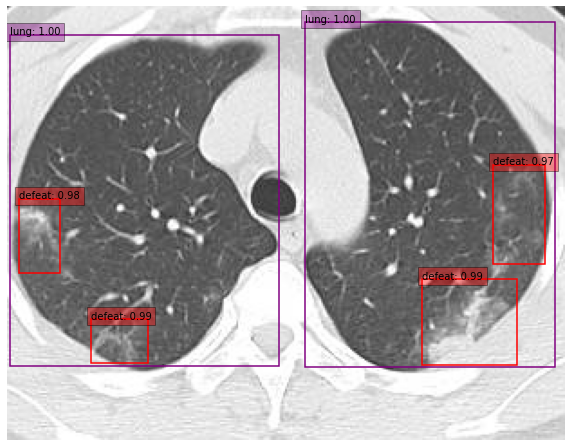

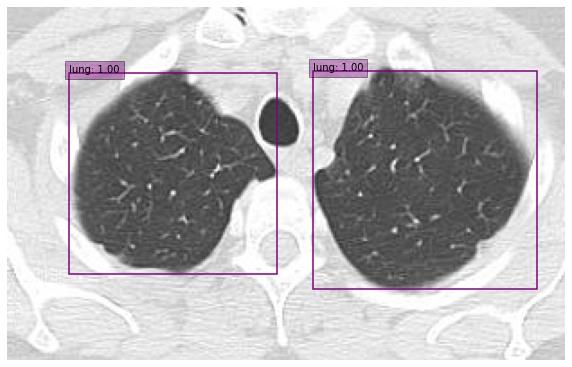

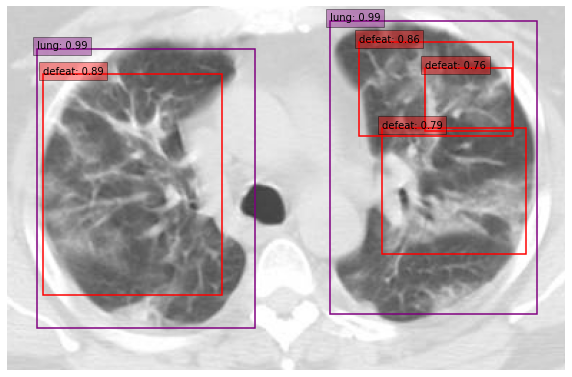

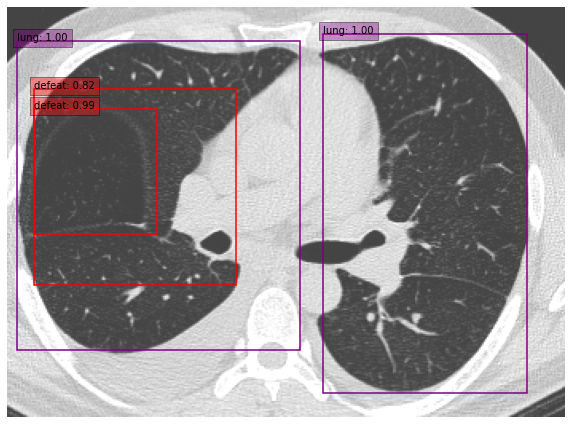

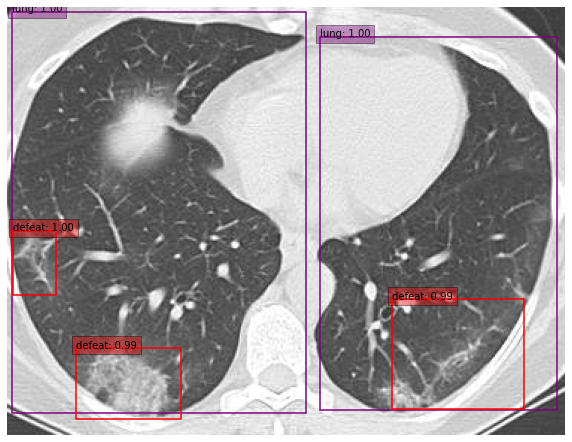

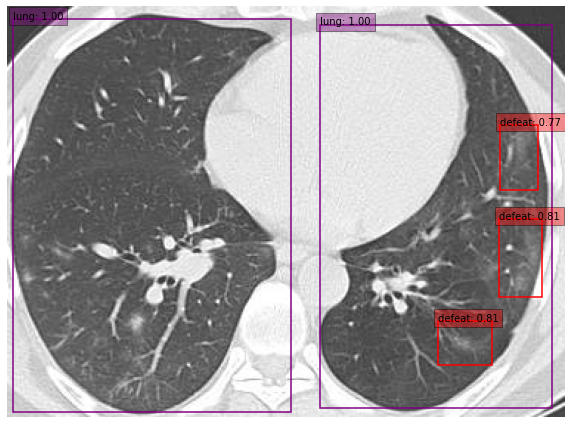

In [ ]:
def prepare_image(image):
  image, _, ratio = resize_and_pad_image(image, jitter=None)
  image = tf.keras.applications.resnet.preprocess_input(image)
  return tf.expand_dims(image, axis=0), ratio

TP = 0
FP = 0
FN = 0

for sample in test_dataset:
  image = tf.cast(sample[0], dtype=tf.float32)
  input_image, ratio = prepare_image(image)
  detections = inference_model.predict(input_image)
  num_detections = detections.valid_detections[0]
  class_names = []

  for j in range(min(len(sample[1]), len(detections.nmsed_boxes[0][:num_detections] / ratio))):
    iou_res = iou(sample[1], detections.nmsed_boxes[0][:num_detections] / ratio)[j][j]
    if iou_res >= 0.8:
      TP += 1
    elif iou_res < 0.8:
      FP += 1
    elif iou_res == 0:
      FN += 1

  for x in detections.nmsed_classes[0][:num_detections]:
    if x == 0:
      class_names.append("lung")
    else:
      class_names.append("defeat")

  visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
        linewidth=1.5)

In [ ]:
precision = TP / (TP + FP)
precision

0.5316455696202531

In [ ]:
recall = TP / (TP + FN)
recall

1.0

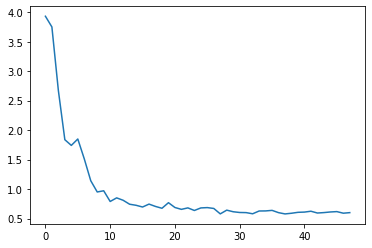

In [ ]:
plt.plot(history.history["val_loss"])